In [1]:
using StochasticDiffEq, Plots, DiffEqDevTools, SDEProblemLibrary
import SDEProblemLibrary: prob_sde_additivesystem,
            prob_sde_additive, prob_sde_2Dlinear, prob_sde_linear, prob_sde_wave
const N = 20

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Module Symbolics with build ID ffffffff-ffff-ffff-0004-adb45004a3f1 is missing from the cache.
│ This may mean Symbolics [0c5d862f-8b57-4792-8d23-62f2024744c7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
┌ Warning: Module Symbolics with build ID ffffffff-ffff-ffff-0004-adb45004a3f1 is missing from the cache.
│ This may mean Symbolics [0c5d862f-8b57-4792-8d23-62f2024744c7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
┌ Warning: Module Symbolics with build ID ffffffff-ffff-ffff-0004-adb4500

1000

┌ Info: Error calculation: 1/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/packages/DiffEqDevTools/xzkgi/src/benchmark.jl:560
┌ Info: Error calculation: 2/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/packages/DiffEqDevTools/xzkgi/src/benchmark.jl:560
┌ Info: Error calculation: 3/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/packages/DiffEqDevTools/xzkgi/src/benchmark.jl:560
┌ Info: Error calculation: 4/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/packages/DiffEqDevTools/xzkgi/src/benchmark.jl:560
┌ Info: Error calculation: 5/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/packages/DiffEqDevTools/xzkgi/src/benchmark.jl:560
┌ Info: Error calculation: 6/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/packages/DiffEqDevTools/xzkgi/src/benchmark.jl:560
┌ Info: Error calculation: 7/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/packages/DiffEqDevTools/xzkgi/src/benchmark.jl:560
┌ Info: Error calculation: 8/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/packages/DiffEqDevTools/xzkgi/src/benchmark

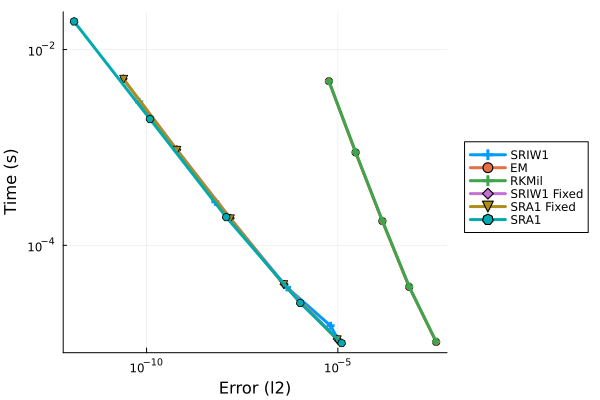

In [2]:
prob = prob_sde_additive
prob = remake(prob,tspan=(0.0,1.0))

reltols = 1.0 ./ 10.0 .^ (1:5)
abstols = reltols#[0.0 for i in eachindex(reltols)]

setups = [Dict(:alg=>SRIW1())
          Dict(:alg=>EM(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1))
          Dict(:alg=>RKMil(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1),:adaptive=>false)
          Dict(:alg=>SRIW1(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1),:adaptive=>false)
          Dict(:alg=>SRA1(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1),:adaptive=>false)
          Dict(:alg=>SRA1())
          ]
names = ["SRIW1","EM","RKMil","SRIW1 Fixed","SRA1 Fixed","SRA1"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;numruns=N,names=names,maxiters=1e7,error_estimate=:l2)
plot(wp)

In [2]:
using QuantumOptics, DiffEqNoiseProcess, DifferentialEquations, SparseArrays, StaticArrays, BenchmarkTools, DiffEqDevTools, DiffEqBase

function smoothstep!(x)
    if x < 0
        return 0
    elseif x > 1
        return 1
    else
        return 3*x^2 - 2*x^3
    end
end

Nspin = 10
κ = 2π*0.15 # MHz
Δc = 2π*20 # MHz
ωz = 2π*0.01 # MHz
seed = 1729
tmax = 50.0 # μs
recordtimes = 50
tspan = range(0.0, tmax, recordtimes)

sb = SpinBasis(Nspin // 2)
Sx = sigmax(sb) / 2
Sy = sigmay(sb) / 2
Sz = sigmaz(sb) / 2
idOp = identityoperator(sb)
ψ0 = spindown(sb)
ψ0 = normalize!(ψ0)
Q0 = 0 # charge on the photodiode at time 0
cl0 = ComplexF64[Q0]
ψ_sc0 = semiclassical.State(ψ0, cl0)

stateG = copy(ψ_sc0)
dstateG = copy(ψ_sc0)
Nq = length(ψ_sc0.quantum)
Nc = length(ψ_sc0.classical)
Ntot = Nq + Nc
u0 = zeros(ComplexF64, Ntot)
semiclassical.recast!(u0, ψ_sc0)
# u0 = zeros(ComplexF64, Ntot)
# semiclassical.recast!(u0, ψ_sc0)
gc = sqrt(ωz*(Δc^2 + κ^2)/abs(Nspin*Δc))
grel!(t) = 1.1*smoothstep!(t/200.)

αplus = Δc/(-Δc + ωz - im*κ) + Δc/(-Δc - ωz - im*κ)
αminus = Δc/(-Δc + ωz - im*κ) - Δc/(-Δc - ωz - im*κ)

C0 = gc*sqrt(κ)/(2*Δc)*(αplus*Sx+im*αminus*Sy)
C!(t) = grel!(t)*C0

H0T1 = ωz*Sz
H0T2 = (gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy)
function H0!(t)
    return H0T1 - H0T2*(grel!(t))^2
end
function H_nl!(ψ,t)
    Ct = C!(t)
    return im * expect(dagger(Ct), normalize(ψ)) * Ct - 0.5im * dagger(Ct) * Ct - 0.5im * expect(dagger(Ct), normalize(ψ)) * expect(Ct, normalize(ψ)) * idOp
end
fdet_heterodyne!(t, ψ) = H0!(t) + H_nl!(ψ, t)
function fst_heterodyne!(t, ψ)
    Ct = C!(t)
    return [(Ct - expect(Ct, normalize(ψ))*idOp)/sqrt(2), im*(Ct - expect(Ct, normalize(ψ))*idOp)/sqrt(2)]
end

function f!(du, u, p, t)
    semiclassical.recast!(dstateG, du)
    semiclassical.recast!(stateG, u)
    timeevolution.dschroedinger_dynamic!(dstateG.quantum, fdet_heterodyne!, stateG.quantum, t)
    dstateG.classical[1] = expect(C!(t), normalize!(stateG.quantum))
    semiclassical.recast!(du, dstateG)
end

num_noise = length(fst_heterodyne!(0., ψ_sc0.quantum))
noise_prototype = zeros(ComplexF64, (Ntot, num_noise))

function g!(du, u, p, t)
    semiclassical.recast!(stateG, u)
    dx = @view du[1:Nq,:]
    stochastic.dschroedinger_stochastic(dx, t, stateG.quantum, fst_heterodyne!, dstateG.quantum, num_noise)
    du[Nq+1, 1] = 1.0/sqrt(2)
    du[Nq+1, 2] = 1.0im/sqrt(2)
    du
end

Base.@pure pure_inference(fout,T) = Core.Compiler.return_type(fout, T)

function fout(t, state)
    copy(state)
end
function fout_(x, t, integrator)
    semiclassical.recast!(stateG,x)
    copy(stateG)
end

out_type = pure_inference(fout, Tuple{eltype(tspan),typeof(ψ_sc0)})
dts = (2//1) .^(-12:-2)
psi_ts = Vector{Vector{out_type}}(undef, 0)
err_ts = Vector{Vector{Float64}}(undef, 0)
err_ts_renorm = Vector{Vector{Float64}}(undef, 0)
tout_course = nothing
function norm_func(u, t, integrator) 
    semiclassical.recast!(stateG, u)
    normalize!(stateG)
    semiclassical.recast!(u, stateG)
end
ncb = DiffEqCallbacks.FunctionCallingCallback(norm_func;
            func_everystep=true,
            func_start=false)
out = DiffEqCallbacks.SavedValues(eltype(tspan),out_type)
scb = DiffEqCallbacks.SavingCallback(fout_,out,saveat=tspan,
                                        save_everystep=false,
                                        save_start = false,
                                        tdir = first(tspan)<last(tspan) ? one(eltype(tspan)) : -one(eltype(tspan)))
full_cb = OrdinaryDiffEq.CallbackSet(nothing, ncb, scb)
CurrW = RealWienerProcess!(0.0, zeros(num_noise))
prob = SDEProblem(f!,g!, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype, noise=CurrW);

In [3]:
reltols = 1.0 ./ 10.0 .^ (1:3)
abstols = reltols#[0.0 for i in eachindex(reltols)]

setups = [Dict(:alg=>EM(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>false),
 Dict(:alg=>LambaEM(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>false),
 Dict(:alg=>EulerHeun(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>false),
 Dict(:alg=>LambaEulerHeun(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>false),
 Dict(:alg=>RKMilCommute(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>false),
 Dict(:alg=>RKMilGeneral(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>false)]
#  Dict(:alg=>WangLi3SMil_A(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1),:adaptive=>false),
#  Dict(:alg=>WangLi3SMil_B(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1),:adaptive=>false),
#  Dict(:alg=>WangLi3SMil_C(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1),:adaptive=>false),
#  Dict(:alg=>WangLi3SMil_D(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1),:adaptive=>false),
#  Dict(:alg=>WangLi3SMil_E(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1),:adaptive=>false),
#  Dict(:alg=>WangLi3SMil_F(),:dts=>1.0./5.0.^((1:length(reltols)) .+ 1),:adaptive=>false)]

names = ["EM", "LambaEM", "EulerHeun", "LambaEulerHeun", "RKMilCommute", "RKMilGeneral"]#, "WangLi3SMil_A", "WangLi3SMil_B", "WangLi3SMil_C", "WangLi3SMil_D", "WangLi3SMil_E", "WangLi3SMil_F"]

wp = WorkPrecisionSet(prob,abstols,reltols,setups,1//2^(10);numruns=5,names=names,maxiters=1e7,error_estimate=:l2,appxsol_setup=Dict(:alg=>RKMilGeneral(;ii_approx=IICommutative())))
plot(wp)

┌ Info: Error calculation: 1/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 2/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 3/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 4/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 5/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 6/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 7/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 8/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 9/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/D

MethodError: MethodError: no method matching isless(::ComplexF64, ::ComplexF64)

Closest candidates are:
  isless(!Matched::Missing, ::Any)
   @ Base missing.jl:87
  isless(::Any, !Matched::Missing)
   @ Base missing.jl:88
  isless(::Number, !Matched::Discontinuity)
   @ DelayDiffEq ~/.julia/packages/DelayDiffEq/kNDLE/src/discontinuity_type.jl:26
  ...


In [4]:
reltols = 1.0 ./ 10.0 .^ (1:3)
abstols = reltols#[0.0 for i in eachindex(reltols)]

setups = [Dict(:alg=>LambaEM(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>true),
 Dict(:alg=>LambaEulerHeun(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>true),
 Dict(:alg=>RKMilCommute(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>true),
 Dict(:alg=>RKMilGeneral(),:dts=>1.0./2.0.^((1:length(reltols)) .+ 3),:adaptive=>true)]

names = ["LambaEM", "LambaEulerHeun", "RKMilCommute", "RKMilGeneral"]

wp = WorkPrecisionSet(prob,abstols,reltols,setups,1//2^(11);numruns=20,names=names,maxiters=1e7,error_estimate=:l2,appxsol_setup=Dict(:alg=>RKMilGeneral(;ii_approx=IICommutative())))
plot(wp)

┌ Info: Error calculation: 1/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 2/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 3/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 4/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 5/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 6/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 7/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 8/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/DiffEqDevTools/src/benchmark.jl:562
┌ Info: Error calculation: 9/20
└ @ DiffEqDevTools /Users/henryhunt/.julia/dev/D

MethodError: MethodError: no method matching isless(::ComplexF64, ::ComplexF64)

Closest candidates are:
  isless(!Matched::Missing, ::Any)
   @ Base missing.jl:87
  isless(::Any, !Matched::Missing)
   @ Base missing.jl:88
  isless(::Number, !Matched::Discontinuity)
   @ DelayDiffEq ~/.julia/packages/DelayDiffEq/kNDLE/src/discontinuity_type.jl:26
  ...
